In [28]:
import pandas as pd
import numpy as np

In [29]:
filtered_data = pd.read_csv('filtered_data.csv')

In [30]:
filtered_data

,iCIK,iCUSIP,pSP_TICKER,iPERIOD_END,iQTY,iMARKET_VALUE,iLONG_FRACTION,pSP_VOLUME,pSP_OPEN,pSP_HIGH,pSP_LOW,pSP_CLOSE,daily_return
0,2230,20030N101,CMCSA,2013-09-30,452300.0,20421000.0,0.015565,36443680,22.115,22.655,22.115,22.5575,0.020009
1,2230,00817Y108,AET,2013-09-30,205000.0,13124000.0,0.010003,1860220,63.900,64.410,63.520,64.0200,0.001878
2,2230,17275R102,CSCO,2013-09-30,700000.0,16394000.0,0.012495,40289820,23.120,23.530,23.020,23.4310,0.013452
3,2230,30219G108,ESRX,2013-09-30,255000.0,15754000.0,0.012008,5386448,61.620,62.150,61.200,61.8000,0.002921
4,2230,806857108,SLB,2013-09-30,138300.0,12220000.0,0.009314,5597176,87.490,88.880,87.160,88.3600,0.009944
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18276747,1812492,48661E108,KMF,2020-03-31,46385.0,154000.0,0.001465,765601,3.010,3.410,3.000,3.3300,0.106312
18276748,1812492,46435G409,IVLU,2020-03-31,1999.0,35000.0,0.000333,214100,17.490,17.760,17.400,17.6000,0.006289
18276749,1812492,74347R818,SAA,2020-03-31,57.0,3000.0,0.000029,8200,44.930,44.930,43.790,44.0100,-0.020476
18276750,1812492,89147L886,TYG,2020-03-31,388.0,1000.0,0.000010,405806,9.320,10.680,9.200,10.2400,0.098712


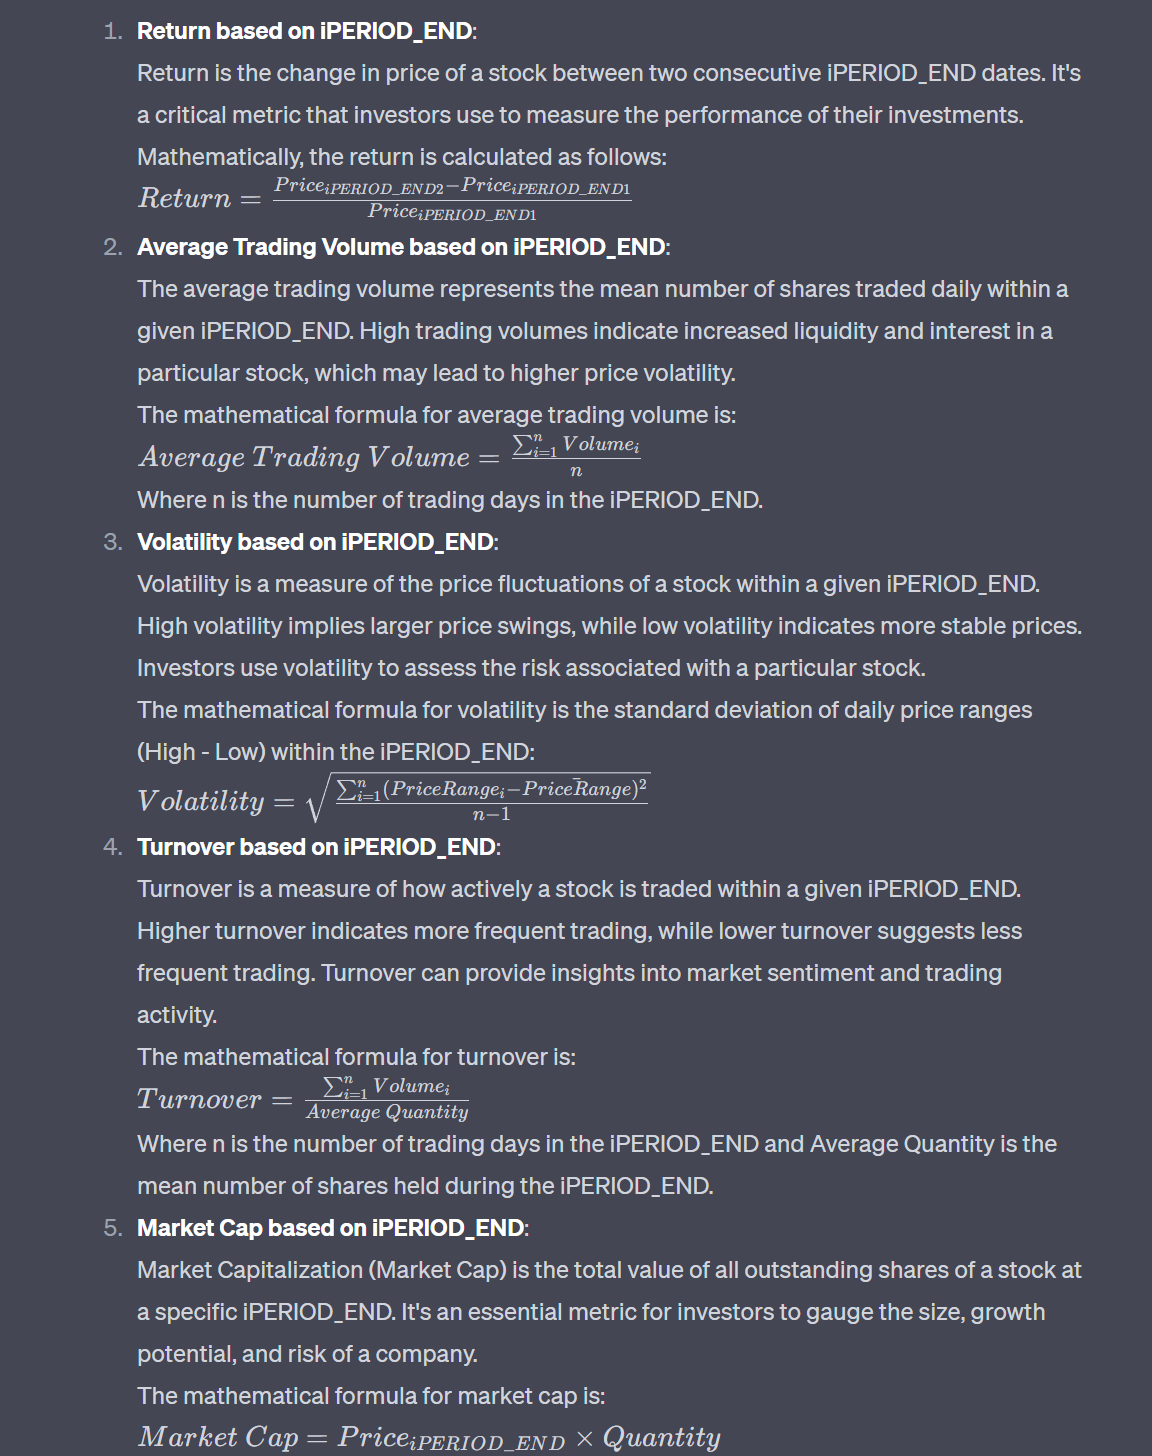

In [33]:
# Assuming 'filtered_data' is a pandas DataFrame containing your data
filtered_data['iPERIOD_END'] = pd.to_datetime(filtered_data['iPERIOD_END'])

# 1. Return based on iPERIOD_END
returns = filtered_data.groupby(['iCUSIP', 'iPERIOD_END'])['pSP_CLOSE'].agg(['first', 'last']).reset_index()
returns['next_period_close'] = returns.groupby('iCUSIP')['last'].shift(-1)
returns['return'] = (returns['next_period_close'] - returns['first']) / returns['first']
filtered_data = pd.merge(filtered_data, returns[['iCUSIP', 'iPERIOD_END', 'return']], on=['iCUSIP', 'iPERIOD_END'])

# 2. Average Trading Volume based on iPERIOD_END
average_volume = filtered_data.groupby(['iCUSIP', 'iPERIOD_END'])['pSP_VOLUME'].mean().reset_index()
average_volume.rename(columns={'pSP_VOLUME': 'average_volume'}, inplace=True)
filtered_data = pd.merge(filtered_data, average_volume, on=['iCUSIP', 'iPERIOD_END'])

# 3. Volatility based on iPERIOD_END
volatility = filtered_data.groupby(['iCUSIP'])['pSP_CLOSE'].apply(lambda x: x.pct_change().std()).reset_index()
volatility.rename(columns={'pSP_CLOSE': 'volatility'}, inplace=True)
filtered_data = pd.merge(filtered_data, volatility, on=['iCUSIP'])

# 4. Turnover based on iPERIOD_END
turnover = filtered_data.groupby(['iCUSIP', 'iPERIOD_END']).agg({'pSP_VOLUME': 'sum', 'iQTY': 'mean'}).reset_index()
turnover['turnover'] = turnover['pSP_VOLUME'] / turnover['iQTY']
filtered_data = pd.merge(filtered_data, turnover[['iCUSIP', 'iPERIOD_END', 'turnover']], on=['iCUSIP', 'iPERIOD_END'])

# 5. Market Cap based on iPERIOD_END
filtered_data['market_cap'] = filtered_data['pSP_CLOSE'] * filtered_data['iQTY']


In [36]:
# Count rows in the original DataFrame
original_row_count = len(filtered_data)

# Drop rows with 0 or NaN values
filtered_data = filtered_data.replace(0, pd.NA)
filtered_data = filtered_data.dropna()

# Count rows in the cleaned DataFrame
cleaned_row_count = len(filtered_data)

# Calculate and print the number of dropped rows
dropped_rows = original_row_count - cleaned_row_count

Dropped rows: 3258831


In [37]:
print(f"Dropped rows percentage: {dropped_rows/original_row_count}")

Dropped rows percentage: 0.1783047119094246


In [38]:
filtered_data.to_csv('cleaned_filtered_data.csv', index=False)